The goal is to build a binary classification model using PyTorch that determines if an individual earns more than $50K based on a set of continuous and categorical variables. The Census Income dataset available at <a href = 'http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a> was used for training. The full dataset has 48,842 entries. For the exercise the number of records was reduced to 30000, some fields and null values were removed.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
# load the dataset
df = pd.read_csv('./income.csv')

In [3]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

In [5]:
# separate continuous, categorical and label columns
ctg_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

In [6]:
# convert categorical columns to category dtypes
for category in ctg_cols:
    df[category] = df[category].astype('category')

In [8]:
# set the embedding sizes
ctg_sizes = [len(df[col].cat.categories) for col in ctg_cols]
emb_sizes = [(size, min(50, (size+1)//2)) for size in ctg_sizes]
emb_sizes

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [9]:
# create an array of categorical values
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

ctgs = np.stack([sx,ed,ms,wc,oc], 1)

ctgs[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

In [11]:
# convert to tensor
ctgs = torch.tensor(ctgs, dtype=torch.int64)

In [12]:
# create an array of continuous values
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]])

In [13]:
# convert to tensor
conts = torch.tensor(conts, dtype=torch.float)

In [14]:
# create a label tensor
y = torch.tensor(df[y_col].values).flatten()

In [16]:
# create train and test sets
b = 30000 # batch size
t = 5000  # test size

ctg_train = ctgs[:b-t]
ctg_test  = ctgs[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

In [17]:
# define a tabular model
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # call the parent __init__
        super().__init__()
        
        # set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # hold a list of layers
        layerlist = []
        
        # store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # set up model layers
        x = self.layers(x)
        return x

In [18]:
model = TabularModel(emb_sizes, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [19]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# train the model
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(ctg_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 0.72960740
epoch:  26  loss: 0.56691861
epoch:  51  loss: 0.50800699
epoch:  76  loss: 0.46463007
epoch: 101  loss: 0.42957038
epoch: 126  loss: 0.40131223
epoch: 151  loss: 0.38036552
epoch: 176  loss: 0.36433348
epoch: 201  loss: 0.34969598
epoch: 226  loss: 0.33765933
epoch: 251  loss: 0.33129632
epoch: 276  loss: 0.32422897
epoch: 300  loss: 0.32000601

Duration: 19 seconds


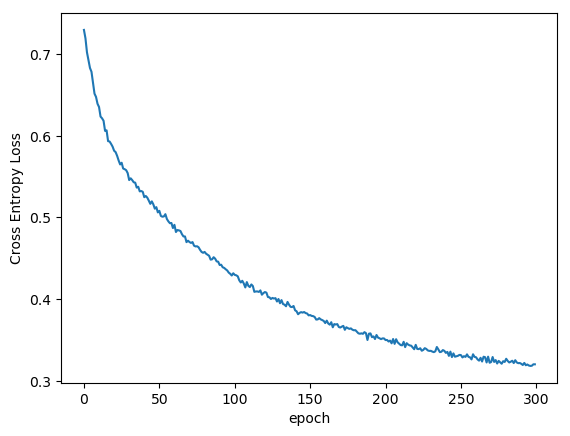

In [22]:
# plot the Cross Entropy Loss against epochs
plt.plot(range(epochs), [i.item() for i in losses])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [24]:
# evaluate the test set
with torch.no_grad():
    y_val = model(ctg_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.32411984


In [25]:
# calculate the overall accuracy
rows = len(y_test)
correct = 0

for i in range(rows):

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4223 out of 5000 = 84.46% correct


In [26]:
# feed new data through the trained model
def test_data(mdl):
    # input new data
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # preprocess the data
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # create categorical and continuous tensors
    ctgs = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # set model to eval mode
    mdl.eval()

    # pass new data through the model without backpropagation
    with torch.no_grad():
        z = mdl(ctgs, conts).argmax().item()

    print(f'\nThe predicted label is {z}')

In [27]:
test_data(model)
# the predicted label is 0 which is less than $50K

What is the person's age? (18-90)  22
What is the person's sex? (Male/Female) male
What is the person's education level? (3-16) 12
What is the person's marital status? married
What is the person's workclass? private
What is the person's occupation? sales
How many hours/week are worked? (20-90)  40

The predicted label is 0
